# Using synthetic data, test `xclim` QDM with a "rolling" future CDF

For each future year, select the surrounding `n` years to compute the inverse CDF and only return the given year's bias corrected output. This makes use of an update to our fork of `xclim`

March 2021



In [4]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection
# pip install -e /home/jovyan/xclim 

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-2_9ccqii
  Using cached boltons-20.2.1-py2.py3-none-any.whl (170 kB)
  Using cached cftime-1.4.1-cp38-cp38-manylinux2014_x86_64.whl (322 kB)
  Created wheel for xclim: filename=xclim-0.24.0-py3-none-any.whl size=272391 sha256=aa44583956236178b2bbde3666418814652affac3e2ac6b9d8f0077d9eabbbf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0wawz5u/wheels/d3/2a/fd/4b118244d4c312a9c161b6964c50e3f3df8091188478abbba0
Successfully built xclim
  Attempting uninstall: cftime
    Found existing installation: cftime 1.3.0
    Uninstalling cftime-1.3.0:
      Successfully uninstalled cftime-1.3.0


In [5]:
%matplotlib inline
import xarray as xr
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [6]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [7]:
write_direc = '../figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [8]:
import xclim
from xclim import sdba

## QDM 

I messed with my local copy of `xclim` so there might be print messages. 

In [9]:
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu

## Synth data with `kind="+"` instead of "*"

Now we will test additive variables and other things

copied and adapted functions from ....`xclim/xclim/testing/tests/test_sdba/utils.py` 

#### Note
The following analyses and validation test on a single grid cell. 



In [10]:
# these funcs modified from ~/xclim/xclim/testing/tests/test_sdba/utils.py

# TODO add these funcs to a utils script or something, since they are now in two notebooks: synthetic_test_xclim_qdm.ipynb and this one
def my_series(values, name, start="2000-01-01"):
    import collections

    
    coords = collections.OrderedDict()
    for dim, n in zip(("time", "lon", "lat"), values.shape):
        if dim == "time":
            coords[dim] = pd.date_range(start, periods=n, freq=pd.DateOffset(days=1))
        else:
            coords[dim] = xr.IndexVariable(dim, np.arange(n))

    if name == "tas":
        attrs = {
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
            "units": "K",
            "kind": "+",
        }
    elif name == "pr":
        attrs = {
            "standard_name": "precipitation_flux",
            "cell_methods": "time: sum over day",
            "units": "kg m-2 s-1",
            "kind": "*",
        }

    return xr.DataArray(
        values,
        coords=coords,
        dims=list(coords.keys()),
        name=name,
        attrs=attrs,
    )

def my_dist():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(4, scale=7.5)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(8.15, scale=3.68)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(16, scale=2.63)

    return ref, hist, sim


def my_rvs(n, kind='+', random=True):
    # Frozen distributions
    if kind=='*':
        return tu.cannon_2015_rvs(n, random=random)
    else:
        fd = my_dist()

        if random:
            r = [d.rvs(n) for d in fd]
        else:
            raise NotImplementedError
    #         u = equally_spaced_nodes(n, None)
    #         r = [d.ppf(u) for d in fd]

        return map(lambda x: my_series(x, "tas"), r)

def add_annual_cycle(ds):
    annual_cycle = np.sin(2 * np.pi * (ds.time.dt.dayofyear.values / 365.25 - 0.28)) 
    return (ds + 10*annual_cycle)

def add_simple_trend(ds, totalchange=20):
    trend = np.linspace(0,totalchange,len(ds.time))
    return ds + trend

In [109]:
random = True
n = 40000
nquantiles = 10000 #100
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

ref, hist, sim = my_rvs(n, kind, random=random)


### Day Grouping

In [110]:
# add a simple future trend and annual cycle

ref = add_annual_cycle(ref)
hist = add_annual_cycle(hist)
sim = add_annual_cycle(sim)

simtrend = add_simple_trend(sim, totalchange=20)
simtrend = add_annual_cycle(simtrend)

In [111]:
def remove_leap_days(da):
    noleap = da.where(~((da.time.dt.month == 2) & 
                        (da.time.dt.day == 29)), drop=True)
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    if len(da.time) == len(np.arange(1,366))*len(years):
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
    else:
        # adjust years to leave off last (not-full) year
        years = np.arange(da.time.dt.year.min(),da.time.dt.year.max())
        # create full year time array
        time_array = np.array([np.arange(1,366)]*len(years))
        # creat datenum for last year (if first year, change to min)
        last_yr = [np.arange(1,len(ref['time'].sel(time=str(ref.time.dt.year.max().values)))+1)]*1
        # combine to one new time array
        all_time = np.append(time_array, last_yr)
        
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(all_time.flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
        
    return noleap

In [112]:
ref = remove_leap_days(ref)
hist = remove_leap_days(hist)
sim = remove_leap_days(sim)
simtrend = remove_leap_days(simtrend)

In [113]:
grouper = sdba.Grouper('time.dayofyear', window=31) #"time.dayofyear"
QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QMdg.train(ref, hist) #(ref, hist)  

DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
DQMdg.train(ref, hist)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QDMdg.train(ref, hist)

In [114]:
hist_qdm = QDMdg.adjust(hist) # previously all withough _noleap
sim_qdm = QDMdg.adjust(sim)
simtrend_qdm = QDMdg.adjust(simtrend)

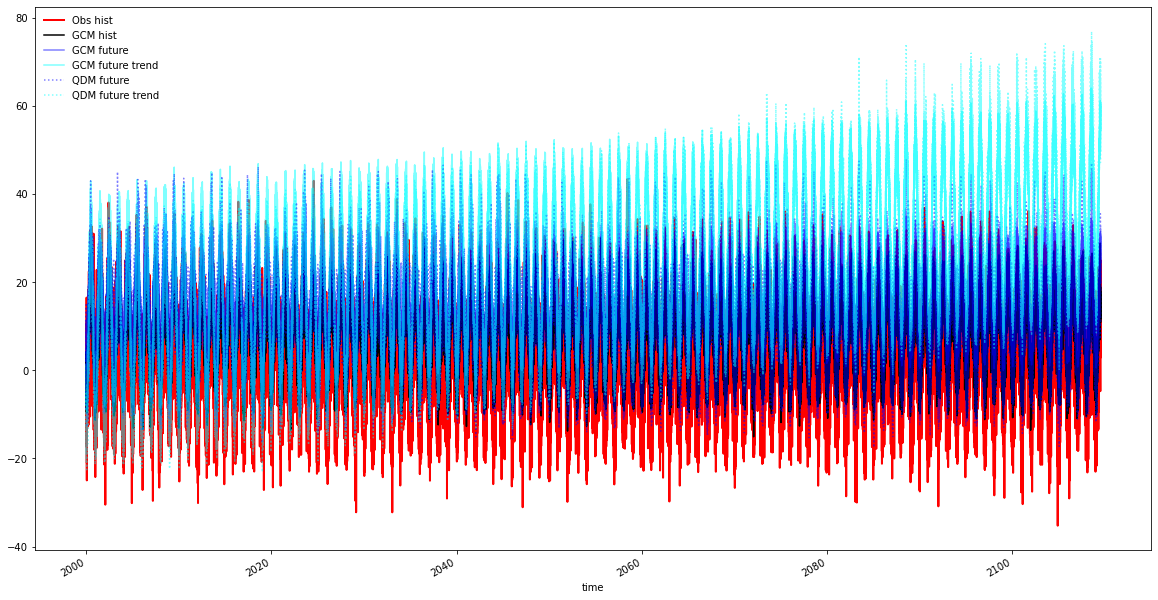

In [115]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="cyan", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

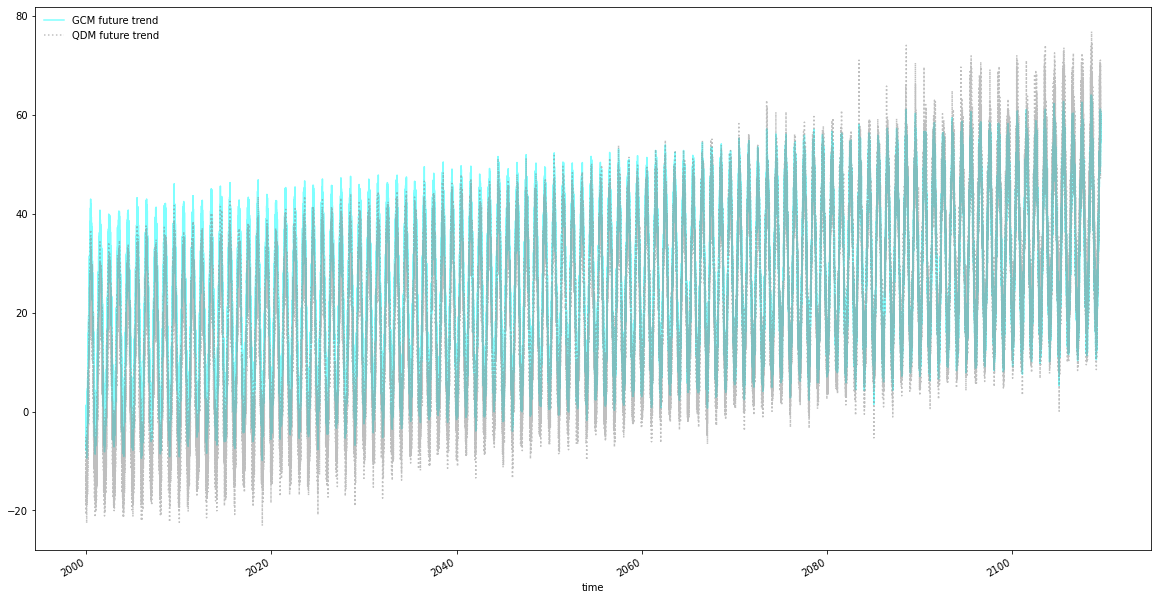

In [116]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

In [117]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend  ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)


all days linear trend
  sim     0.09211604642629143
  QDM sim 0.19180972459305912

  simtrend   20.11460271643205
  QDM simtrend 31.80171562706343


### is the trend preserved?
In `simtrend` we're expecting to see the added trend of `totalchange` above (=20 currently). The uncorrected trend is pretty close to 20, but the default behavior of QDM (`QDM simtrend`) clearly changes that here, where we're just checking the linear trend through all days. The trend is much steeper after QDM and this is true for kind="*" and kind="+"

This outcome may not be applicable to our actual method, which is grouped by day and will have a rolling future cdf. SEE NEXT



# Rolling cdf

here we will loop through years in the future time series and call QDM with the `year` argument, concatenating the results

In [118]:
simy_qdm_list = []
simtrendy_qdm_list = []

roll = 10

# because we're rolling, we can't use the first and last 10 years
bc_years = np.arange(sim.time.dt.year.values[0]+roll,sim.time.dt.year.values[-1]-roll)

for yr in bc_years:
    
    timeslice = slice(str(yr-roll),str(yr+roll))
    
    # testing this on a future with a trend and one without
    simy_qdm_list.append(QDMdg.adjust(sim.sel(time=timeslice), year=yr)) # 
    simtrendy_qdm_list.append(QDMdg.adjust(simtrend.sel(time=timeslice), year=yr)) # , year=yr

simy_qdm = xr.concat(simy_qdm_list, dim='time')
simtrendy_qdm = xr.concat(simtrendy_qdm_list, dim='time')

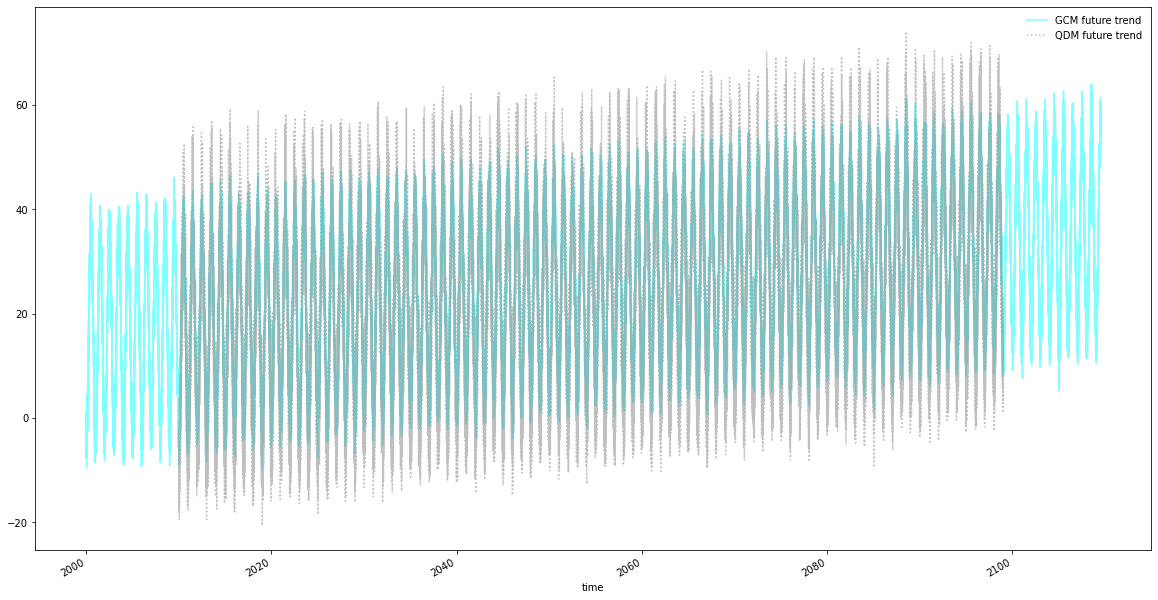

In [119]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrendy_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

In [120]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend                ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend              ', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)
print('  QDM simtrend with roll cdf', sp.stats.linregress(np.arange(len(simtrendy_qdm.time)), simtrendy_qdm.values).slope*n)


all days linear trend
  sim     0.09211604642629143
  QDM sim 0.19180972459305912

  simtrend                 20.11460271643205
  QDM simtrend               31.80171562706343
  QDM simtrend with roll cdf 20.183510405930928


Awesome! Doing a bias correction on a rolling basis maintains the simple linear trend over the whole time series, unlike running QDM on the full time series at once.

### comparing quantiles - are the quantile trends preserved?

In [32]:
from plotting import quantile_compare_plot, compare_quantile_trends_scatter_hist, compare_gcm_qdm_quantiles



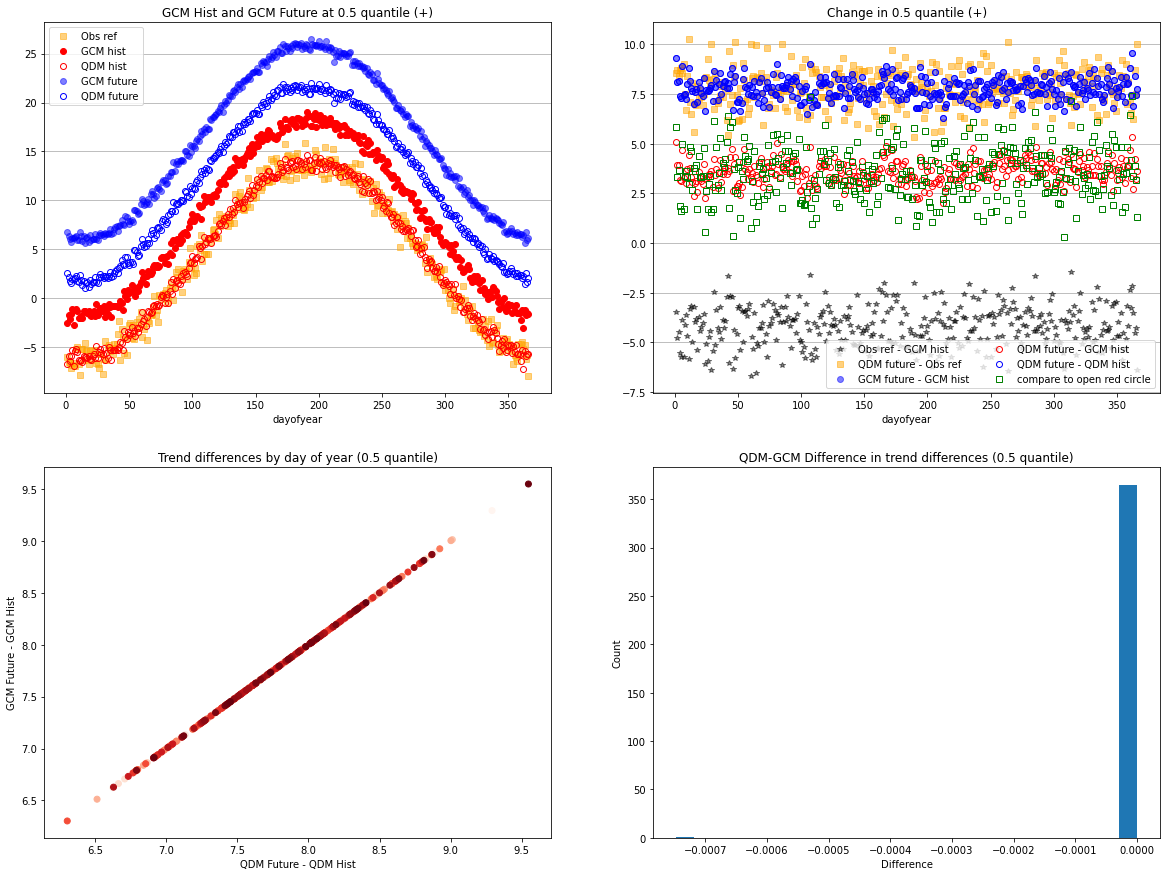

In [122]:
printtofile=False

_ = quantile_compare_plot((ref, hist, sim), (hist_qdm, sim_qdm), kind=kind,grouper='time.dayofyear', quantiles=[.5], tworow=True)


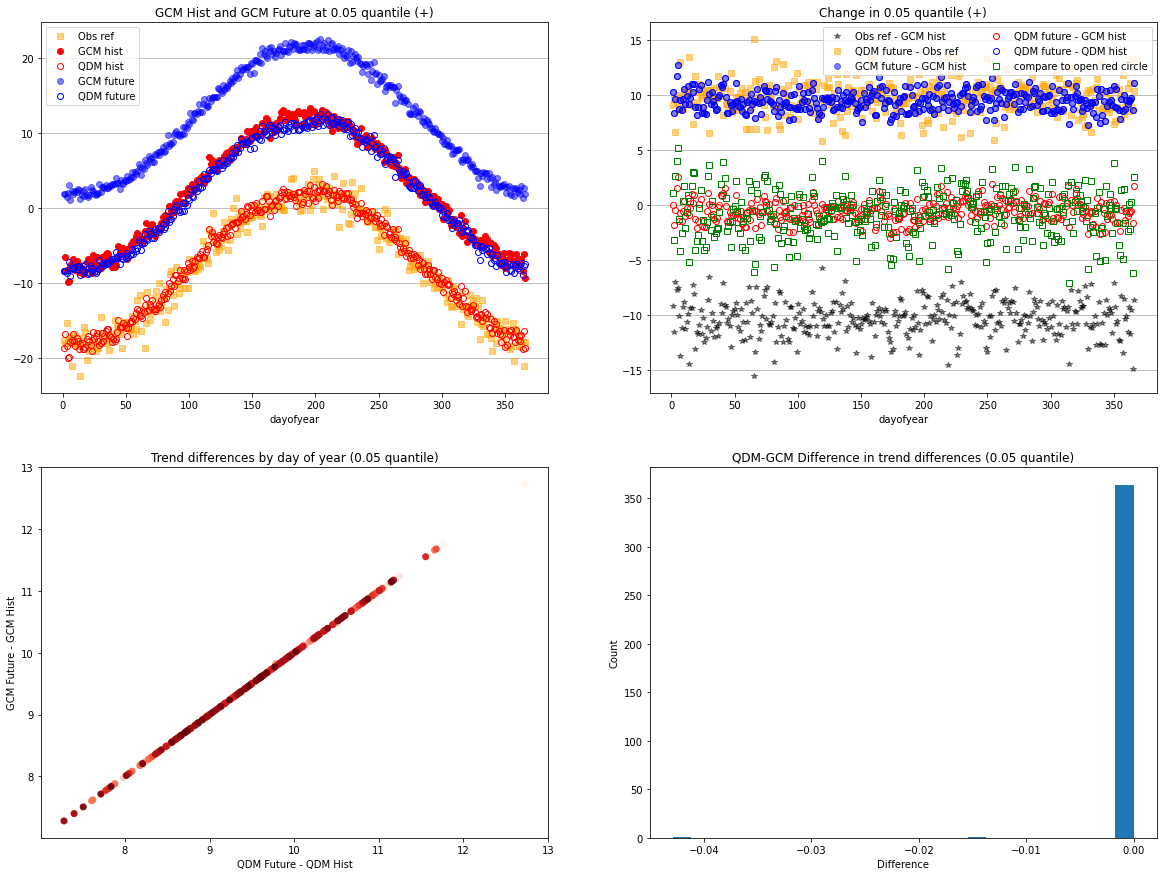

In [105]:
_ = quantile_compare_plot((ref, hist, sim), (hist_qdm, sim_qdm), kind=kind,grouper='time.dayofyear', quantiles=[.05], tworow=True)


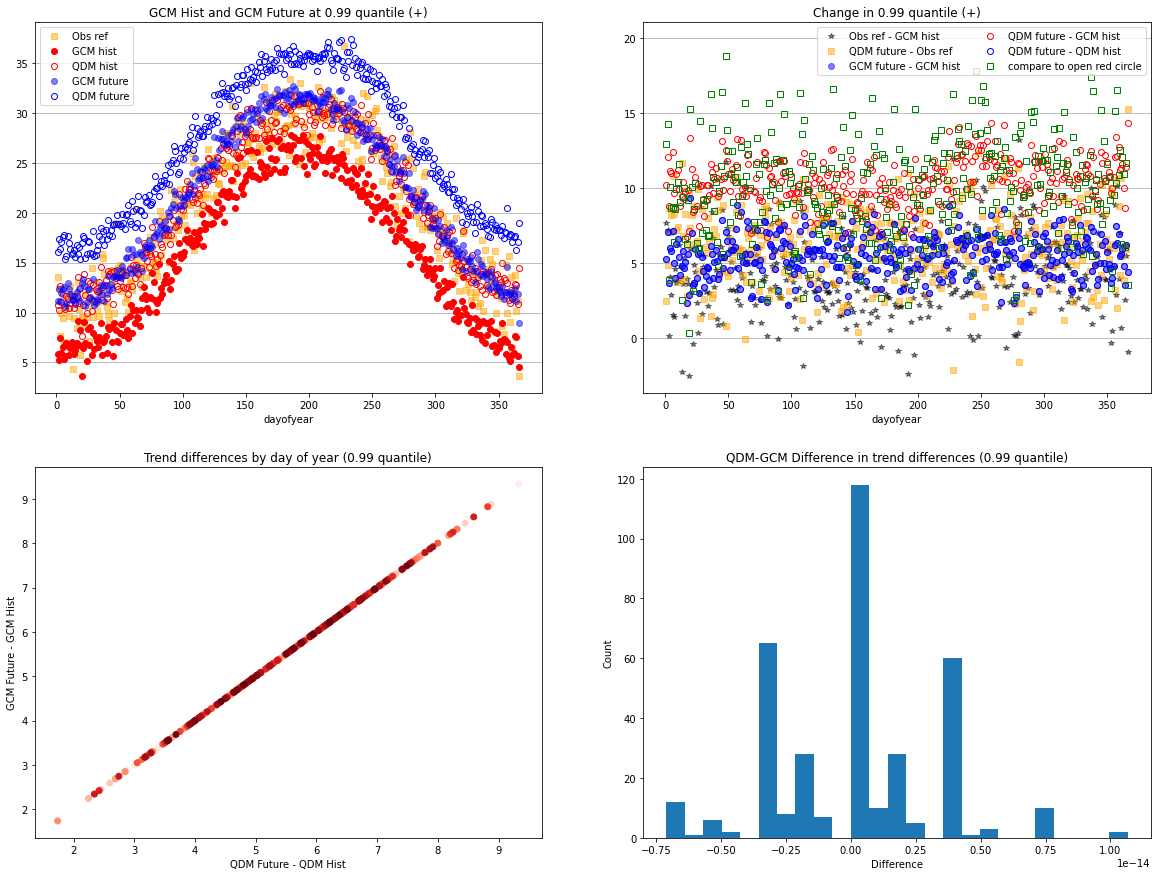

In [106]:
_ = quantile_compare_plot((ref, hist, sim), (hist_qdm, sim_qdm), kind=kind,grouper='time.dayofyear', quantiles=[.99], tworow=True)


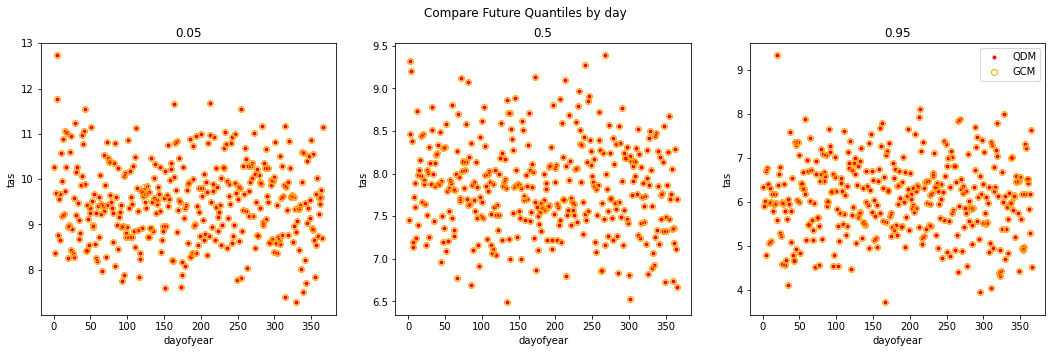

In [107]:
_ = compare_gcm_qdm_quantiles((ref, hist, sim), (hist_qdm, sim_qdm), grouper='time.dayofyear')

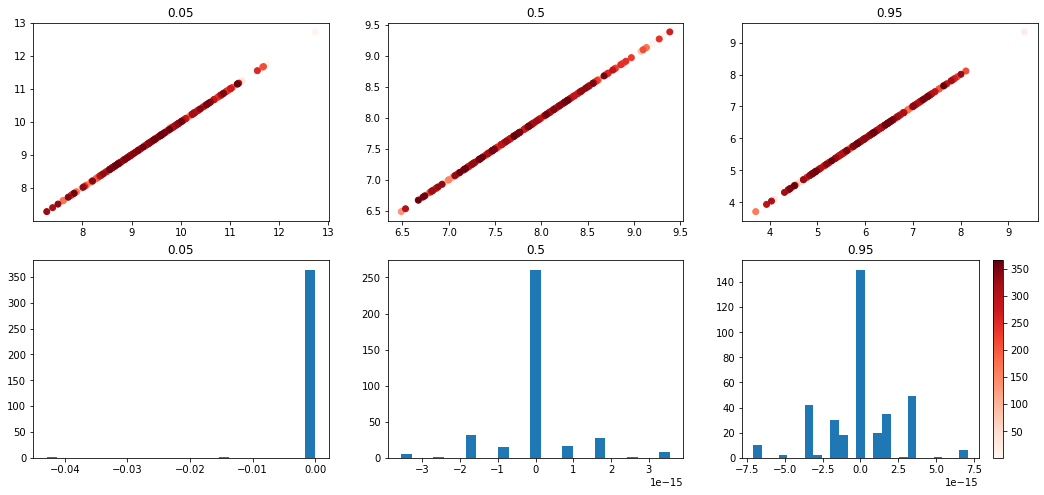

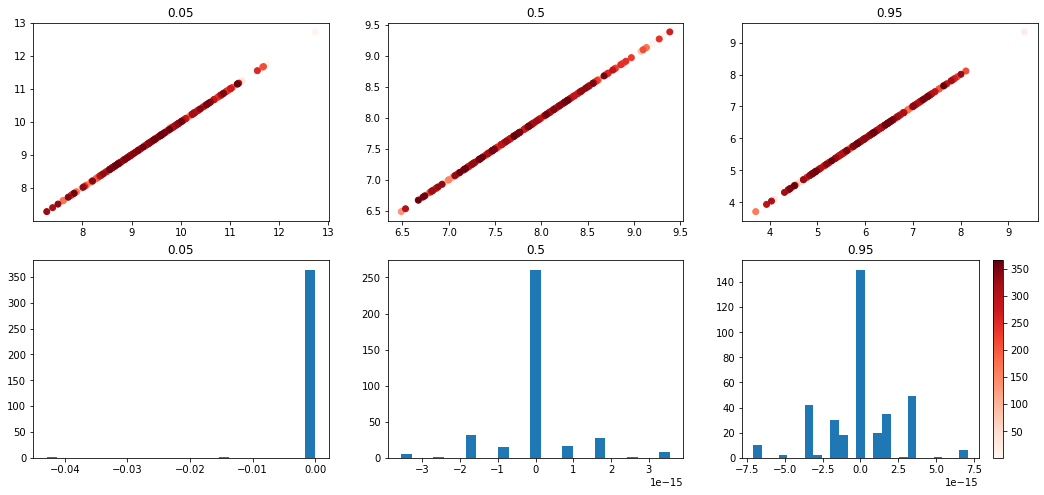

In [108]:
compare_quantile_trends_scatter_hist((ref, hist, sim), (hist_qdm, sim_qdm), grouper='time.dayofyear')

In general, it seems like quantile trends are *mostly* preserved, but not exactly, and they are more off near the tails (see the above histograms).

I'm not sure why these are off at all - some of it could certainly be leap days shifting things. But in `synthetic_test_xclim_qdm.ipynb` I tested the (non-rolling cdf) time series after removing leap years, and there were still differences. This needs testing here with rolling cdfs though. Try removing leap years and re-do the analysis.

Finally, note that there is no `window` here, so need to also re-do this analysis with `grouper="time.dayofyear"` and `window=31`

## TODO
- [X] Remove leap days to see if that improves the quantile comparisons
- [X] Test with a window of 31 days
- [ ] test a rolling object instead of looping through future years (this is low prio, since the current implementation jives well with how we will use argo to submit jobs on azure). But, can we do something like:

```
simrolling = simtrend.rolling(center=True, time=21*365) # or whatever the correct syntax is (also would need to remove leap days for this to work)
simrolling.apply(QDMdg.adjust()) # or it might be: simrolling.reduce(QDMdg.adjust())
```